## Multi-class image classification with convolutional neural nets and transfer learning

### Author/Data-Scientist: Leon Hamnett [(linkedin)](https://www.linkedin.com/in/leon-hamnett/)

### Contents:

1. [Introduction](#intro)
2. [Examine the Dataset](#exam)
3. [Preprocessing](#preprocess)
4. [Model 1](#mod1)
    1. [Training](#train1)
    2. [Evalutation](#eval1)
5. [Model 2 with Transfer learning](#mod2)
    1. [Training](#train2)
    2. [Evalutation](#eval2)
5. [Conclusion](#conclusion)

### Introduction: <a name="intro"></a>

During this notebook, we will be using [this](https://www.kaggle.com/puneet6060/intel-image-classification) kaggle dataset of images to develop a multiple class, image classifier using convolutional neural networks. The dataset contains landscape and urban images and we can  the images are split into buildings, forests, glaciers, mountains, seas and streets.

We will also be using transfer learning to improve the performance of the classifer. 

In [1]:
# Import the tensorflow libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3 #transfer learning
from tensorflow.keras.optimizers import RMSprop #to set custom learning rates
import tensorflow.keras.preprocessing.image as kp

# Import the utility libraries for file manipulation
import os
from os import getcwd
import zipfile
import shutil
import tempfile
import sys, stat 

# Import visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn

# Other libraries
import random
import numpy as np
from sklearn.metrics import confusion_matrix



### Examine the dataset: <a name="exam"></a>

The dataset contains landscape and urban images and is already split into training, test and prediction sets of images. We can see in the training set, the images are split into buildings, forests, glaciers, mountains, seas and streets and have between 2000 and 2500 images in each folder. 

The testing set is also split into the same categories but only has around 500 images in each folder. 

The prediction folder also has around 7000 images, but these are not labelled. If better performance were required in the future, some of these images could be manually labelled and added to the training data to give a better accuracy. 

First we will extract the images into a temporary folder from the zip file and look at a sample of the images from each category to get a feel for the dataset:

In [2]:
#extract images to temp folder
#get path to zip folder on local system
working_dir = os.getcwd()
path_zip_all_images = os.path.join(working_dir,'class_images.zip')
local_zip = path_zip_all_images
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('temp')
zip_ref.close()

#change permissions to enable reading and writing from temp folder
os.chmod('temp',stat.S_IRWXU)

In [3]:
# Define our training and test directory:
train_dir = 'temp/seg_train/seg_train'
test_dir = 'temp/seg_test/seg_test'

# We will take most of the test images to use as a validation set:

# make new folder(s) for validation images

try:
    os.makedirs('temp/valid/street')
    os.makedirs('temp/valid/sea')
    os.makedirs('temp/valid/mountain')
    os.makedirs('temp/valid/glacier')
    os.makedirs('temp/valid/forest')
    os.makedirs('temp/valid/buildings')
    print('directories made')
except OSError:
    print(OSError)
    print('Did not work, check for errors')


directories made


In [4]:
# get list of filenames in each folder for test images
valid_dir = 'temp/valid'
 
test_folders = os.listdir(test_dir) #list folders in test_dir

# go through each folder and randomly choose 90% of test images for validation
for folder in test_folders: #loop through the folders
    folder_path = os.path.join(test_dir,folder) #get the path of each subfolder
    image_list = os.listdir(folder_path) #get list of images in each sub folder
    no_images_in_folder = len(os.listdir(folder_path)) #count images in subfolder
    no_images_to_move = int(no_images_in_folder*0.9) #count half of total images to nearest whole number
    images_to_move = random.sample(image_list,k=no_images_to_move) #choose randomly half of images
    # folder_path_to_move = os.path.join(valid_dir,folder) delete?
    for file in images_to_move:
        image_to_move = os.path.join(test_dir,folder,file) # get full path to image
        image_dest = os.path.join(valid_dir,folder,file) # make full path for destination
        os.replace(image_to_move, image_dest) #move image from source to destination
    
    print('{} folder finished moving'.format(folder)) #confirm each folder has moved the images
    
#check number of images in validation and test folders to be sure

valid_folders = os.listdir(valid_dir) 
for folder in valid_folders: 
    folder_path = os.path.join(valid_dir,folder)
    no_images_in_folder = len(os.listdir(folder_path))
    print('valid folder: {}, # images: {} '.format(folder,no_images_in_folder))
    
for folder in test_folders: 
    folder_path = os.path.join(test_dir,folder)
    no_images_in_folder = len(os.listdir(folder_path))
    print('test folder: {}, # images: {} '.format(folder,no_images_in_folder))
    



street folder finished moving
glacier folder finished moving
sea folder finished moving
forest folder finished moving
buildings folder finished moving
mountain folder finished moving
valid folder: street, # images: 450 
valid folder: glacier, # images: 497 
valid folder: sea, # images: 459 
valid folder: forest, # images: 426 
valid folder: buildings, # images: 393 
valid folder: mountain, # images: 472 
test folder: street, # images: 51 
test folder: glacier, # images: 56 
test folder: sea, # images: 51 
test folder: forest, # images: 48 
test folder: buildings, # images: 44 
test folder: mountain, # images: 53 


Now that we have loaded our images and split them into appropiate train,validatin and testing sets. We can look at some of the images to get a feel for the type of images:

street images: 


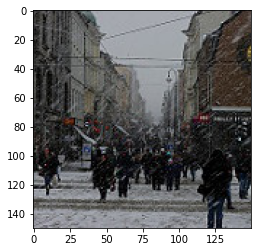

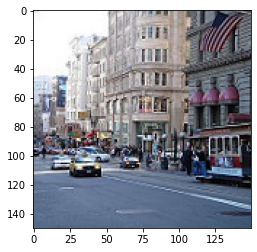

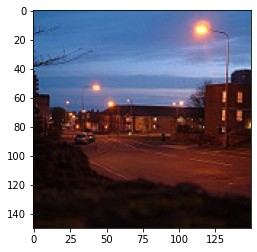

glacier images: 


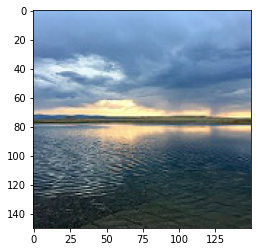

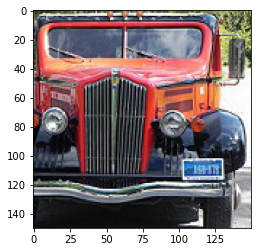

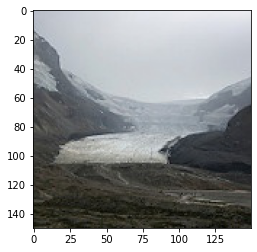

sea images: 


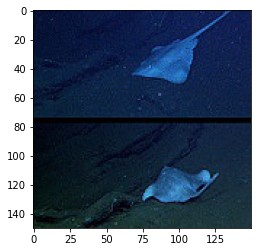

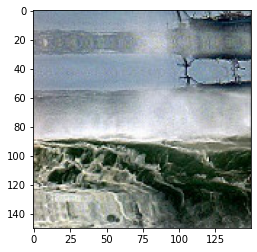

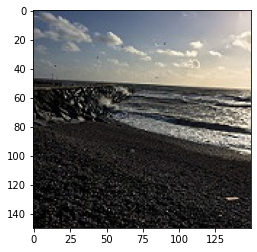

forest images: 


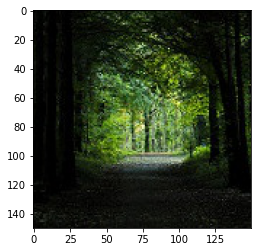

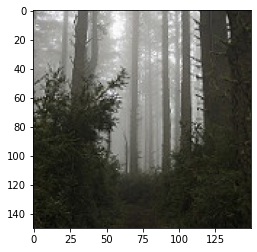

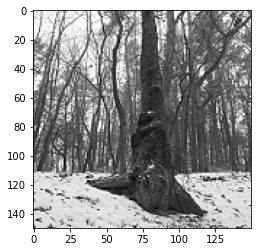

buildings images: 


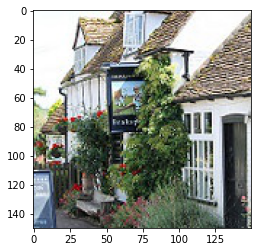

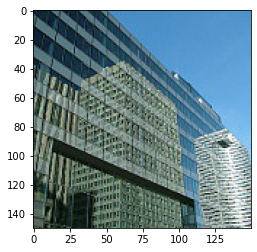

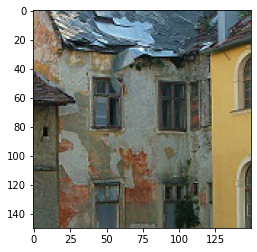

mountain images: 


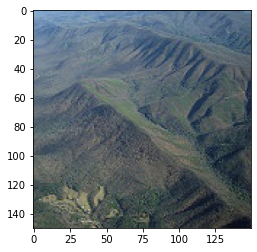

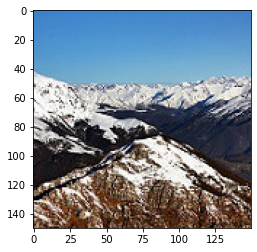

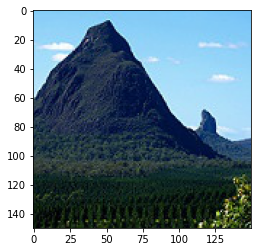

In [5]:
for folder in valid_folders:
    files = os.listdir(os.path.join(valid_dir,folder))
    files_to_show = random.sample(files,3)
    
    print('{} images: '.format(folder))
    for file in files_to_show:
        img_path = os.path.join(valid_dir,folder,file)
        img = mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.show()


We can see from the above images the type of images that we will be working with. 

### Preprocessing: <a name="preprocess"></a>

Now we will perform some preprocessing and create the image piplines to be fed into the classification algorithm:

In [6]:
#confirm directories have been specified correctly
print('training directory: {}'.format(train_dir))
print('validation directory: {}'.format(valid_dir))
print('testing directory: {}'.format(test_dir))

# specifcy the data generator to feed in the training images
# normalise images and augment to give a greater range of training images
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')

#specify the data generators to feed in the validation and testing images
validation_datagen = ImageDataGenerator(rescale = 1./255)
testing_datagen = ImageDataGenerator(rescale = 1./255)

#create generator objects
train_generator = training_datagen.flow_from_directory(
    train_dir,
    shuffle = True,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=40)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(150,150),
    class_mode='categorical',
    shuffle = True,
    batch_size=40)

testing_generator = testing_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=1) #batch size is 1 for easier processing when evaluating the accuracy of the algorithm on test images


training directory: temp/seg_train/seg_train
validation directory: temp/valid
testing directory: temp/seg_test/seg_test
Found 14034 images belonging to 6 classes.
Found 2697 images belonging to 6 classes.
Found 303 images belonging to 6 classes.


### Create the classification model with a convolutional neural net: <a name="model1"></a>

Now we will create the machine learning classification model:

In [7]:
#define the convolutional neural net to be used for the model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1), # drop out to prevent reliance on certain neurons
    # 512 neuron hidden layer to process
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax') # 6 possible output classes
])

We will also create a callback to stop the training when it reaches a predetermined level:

In [8]:
# Define a Callback class that stops training once accuracy reaches 90.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90.0% accuracy so cancelling training!")
      self.model.stop_training = True

### Training the model: <a name="train1"></a>

Now we will compile and train the model:

In [9]:
#compile model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy']) #maybe should be sparse categ

#create another callback for early stopping and assign both callbacks to variable:
callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=4, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

callbacks = [myCallback(),callback2]

#create a history of the model to evaluate model progress and performance
history = model.fit(train_generator, 
                    epochs=10, 
                    steps_per_epoch=10, 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=3,
                    callbacks=callbacks)

Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 1.7996 - accuracy: 0.2400 - val_loss: 1.5576 - val_accuracy: 0.3417
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 1.5832 - accuracy: 0.3475 - val_loss: 1.2804 - val_accuracy: 0.4250
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 1.3933 - accuracy: 0.4400 - val_loss: 1.2273 - val_accuracy: 0.4500
Epoch 4/10
10/10 [==============================] - 13s 1s/step - loss: 1.4622 - accuracy: 0.3825 - val_loss: 1.1706 - val_accuracy: 0.5083
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: 1.3887 - accuracy: 0.4475 - val_loss: 1.2922 - val_accuracy: 0.4167
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 1.3639 - accuracy: 0.4375 - val_loss: 1.1802 - val_accuracy: 0.5333
Epoch 7/10
10/10 [==============================] - 12s 1s/step - loss: 1.3363 - accuracy: 0.4325 - val_loss: 1.0790 - val_accuracy: 0.5750
Epoch 8/10
10/10 [==

###  Performance evaluation: <a name="eval1"></a>

Now we will check the performance of the model:

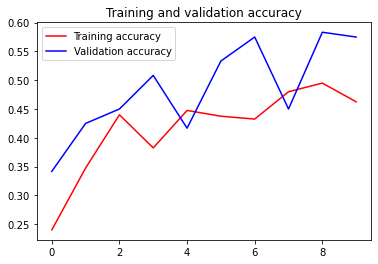

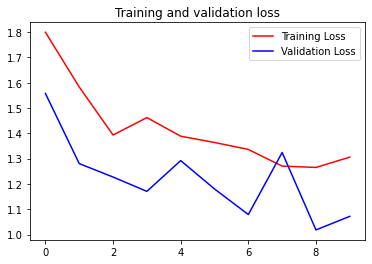

max valid accuracy: 0.5833333134651184


In [10]:
#define variables of interest from history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#create graphs
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print('max valid accuracy: {}'.format(max(val_acc)))

We can see from the example that the accuracies are both still increasing and the losses are still trending downwards and so it seems likely that if we were to continue training the model, we could see further increases in accuracy. We also see we obtained a maximum vlaidation accuracy of around 60%, implying that the model can predict around 60% of images correctly. 

We will now evaluate the first model to see how it performs when classifying the test images to obtain an accuracte measure of the overall accuracy:

In [11]:
#create a new callback to stop the evaluation on the test images
eval_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience=2,min_delta=0.01, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

#evaluate model on test images
model.evaluate_generator(testing_generator,
    steps=1000,
    callbacks=[eval_callback],
    max_queue_size=10,
    workers=1,
    verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
1000/1000 [==============================] - 25s 25ms/step - loss: 1.1624 - accuracy: 0.5640


[1.1623988151550293, 0.5640000104904175]

We can see the final performance of the first model is around 55%.

### Second model with transfer learning: <a name="model1"></a>

Now we will use transfer learning to see if we can increase the accuracy of the classification system when the model is trained for a comparable number of epochs:

In [12]:
#define the previous model to transfer the knowledge from to our model
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                               include_top = False,
                               weights = 'imagenet')

# Make all the layers in the pre-trained model non-trainable to avoid overwriting the weights the model has learnt before
for layer in pre_trained_model.layers:
    layer.trainable = False

  
# Show a summary of the model so we can choose the cut-off point to feed into our model 
pre_trained_model.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
__________________________________________________________________________________________________


Now we have imported the Inception model, we will take the trained model from the Inception model and then take a layer as an output and then use this output as an input into the rest of our model.

We choose a layer away from the bottom of the above model to remove the layers which specialise for the images the Inception model has been trained on. In this case we choose the layer, mixed6 but this is arbitary. Different layers can be chosen to see their impact. 

In [13]:
#set the last layer of the pre-trained model
last_layer = pre_trained_model.get_layer('mixed8')
print('last layer output shape: ', last_layer.output_shape) #check output shape
last_output = last_layer.output


last layer output shape:  (None, 3, 3, 1280)


In [14]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024,activation='relu')(x)
# Add a dropout rate of 0.2 to prevent over reliance on specific neurons
x = layers.Dropout(0.2)(x)                  
# Add a final layer for classification, 6 outputs as we have 6 image classes
x = layers.Dense(6,activation='softmax')(x)           

#create a new model
model2 = Model(pre_trained_model.input, x) 

#compile the new model
model2.compile(optimizer = RMSprop(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics = ['accuracy'])




### Training the second model:  <a name="train2"></a>

In [15]:
#we change the callback slightly 

callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=4, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

callbacks = [myCallback(),callback2]

#we create a new history variable to show the progress of the new model with transfer learning
history2 = model2.fit(train_generator, 
                    epochs=10, 
                    steps_per_epoch=10, 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=3,
                    callbacks=callbacks)

Epoch 1/10
10/10 [==============================] - 80s 8s/step - loss: 15.0833 - accuracy: 0.3100 - val_loss: 2.8918 - val_accuracy: 0.6667
Epoch 2/10
10/10 [==============================] - 58s 6s/step - loss: 2.0610 - accuracy: 0.5750 - val_loss: 2.1751 - val_accuracy: 0.5333
Epoch 3/10
10/10 [==============================] - 58s 6s/step - loss: 1.8813 - accuracy: 0.6100 - val_loss: 0.8386 - val_accuracy: 0.7250
Epoch 4/10
10/10 [==============================] - 75s 8s/step - loss: 1.3169 - accuracy: 0.6675 - val_loss: 0.5740 - val_accuracy: 0.8167
Epoch 5/10
10/10 [==============================] - 89s 9s/step - loss: 1.0965 - accuracy: 0.7025 - val_loss: 0.3456 - val_accuracy: 0.8750
Epoch 6/10
10/10 [==============================] - 116s 12s/step - loss: 1.1724 - accuracy: 0.6675 - val_loss: 0.4758 - val_accuracy: 0.8583
Epoch 7/10
10/10 [==============================] - 86s 9s/step - loss: 0.7568 - accuracy: 0.7325 - val_loss: 0.4614 - val_accuracy: 0.8333
Epoch 8/10
10/10 

### Evaluating the model with transfer learning:  <a name="eval2"></a>

Agan, we will look at the performance metrics of this new model and we can compare them against the intitial model that we created and see how the use of transfer learning affects model performance.

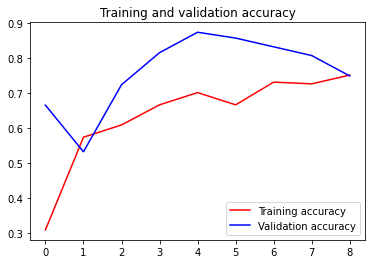

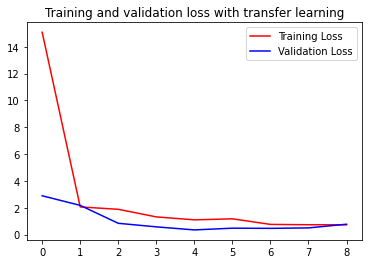

max valid accuracy: 0.875


In [16]:
# get new variables
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(len(acc2))

#plot performance graphs
plt.plot(epochs2, acc2, 'r', label='Training accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs2, loss2, 'r', label='Training Loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation Loss')
plt.title('Training and validation loss with transfer learning')
plt.legend()

plt.show()

print('max valid accuracy: {}'.format(max(val_acc2)))

We can see that the accuracy is much better when the model has transfer learning applied, even when both models have been trained for a comparable period. Now we will evaluate the second model to see how well it classifies the test images to get an accuracte value for the overall accuracy of the model.

In [17]:
#evaluate performance of the second model on classifying the training images

eval_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience=2,min_delta=0.01, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

model2.evaluate_generator(testing_generator,
    steps=1000,
    callbacks=[eval_callback],
    max_queue_size=10,
    workers=1,
    verbose=1)

1000/1000 [==============================] - 468s 468ms/step - loss: 0.7241 - accuracy: 0.7820


[0.7240678071975708, 0.7820000052452087]

We can see that when the model is evaluated against the test data, it gives an accuracy of around 80%, meaning it can classify 8/10 images correctly which is much better than random chance of 1/6.

We will also load some images from the test images and compare the image label and the predicted image, so we can also get a visual idea of how the algorithm is performing. 

In [18]:
# get testing labels and filepaths from the image generators
testing_labels = testing_generator.labels
testing_filepaths = testing_generator.filepaths

#now we will loop through the testing images and make a prediction for each one
predicts = []
for filepath in testing_filepaths:
    temp = kp.load_img(filepath,target_size=(150,150,3))
    array = kp.img_to_array(temp)
    array_stan = array/255.0 #scale
    array_shaped = np.expand_dims(array_stan,axis=0) #get to same dimensions the model is expecting
    predict = model2.predict(array_shaped)
    max_index = np.argmax(predict) #predict is softmax function and so we turn this into an integer classification
    predicts.append(max_index)
    

Now we have the image label and prediction for each of the 303 test images. We will look at a few images to see how the model performs:

Image label 2: glacier
Predicted label 0: building


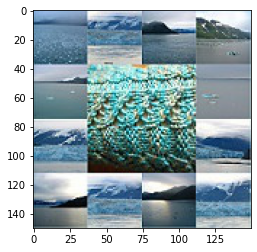

Image label 3: mountain
Predicted label 3: mountain


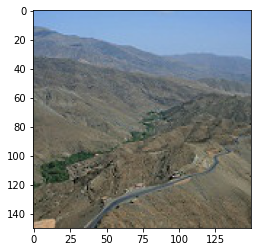

Image label 3: mountain
Predicted label 3: mountain


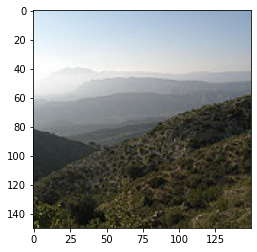

Image label 1: forest
Predicted label 1: forest


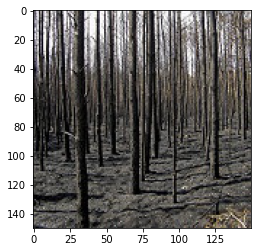

Image label 2: glacier
Predicted label 2: glacier


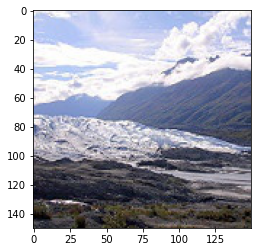

Image label 0: building
Predicted label 0: building


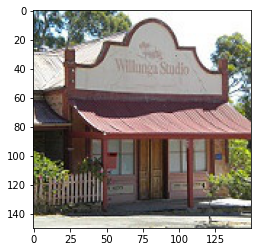

Image label 4: sea
Predicted label 1: forest


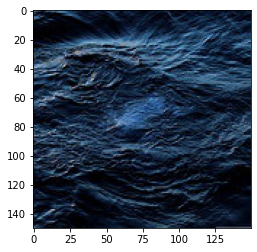

Image label 5: street
Predicted label 5: street


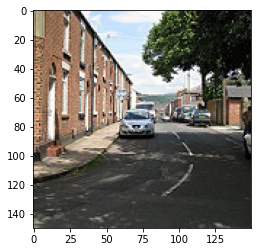

Image label 1: forest
Predicted label 1: forest


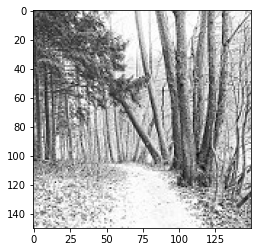

Image label 0: building
Predicted label 0: building


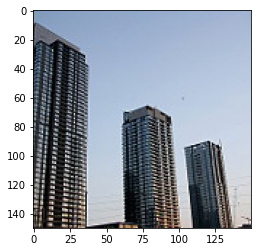

In [19]:
#function to take integer classification and turn it into a word description
def label(input):
    cat = input
    if cat == 0:
        return 'building'
    elif cat == 1:
        return 'forest'
    elif cat == 2:
        return 'glacier'
    elif cat == 3:
        return 'mountain'
    elif cat == 4:
        return 'sea'
    elif cat == 5:
        return 'street'

#loop through some images and display the label, prediction and image:
to_check = random.sample(range(len(testing_filepaths)),10) # choose random indices from all testing files
for x in to_check: 
    print('Image label {}: {}'.format(testing_labels[x],label(testing_labels[x])))
    print('Predicted label {}: {}'.format(predicts[x],label(predicts[x])))
    img = mpimg.imread(testing_filepaths[x])
    imgplot = plt.imshow(img)
    plt.show()
    

We can see from the above images that the classifier is mostly classifying images correctly. We will also check the confusion matrix to see if there is a paricular type of classification that the model is struggling with. 

[[40  0  0  0  0  4]
 [ 0 48  0  0  0  0]
 [ 2  0 49  3  0  2]
 [ 0  0 13 39  0  1]
 [ 5  6 11 13 13  3]
 [ 4  0  0  0  0 47]]


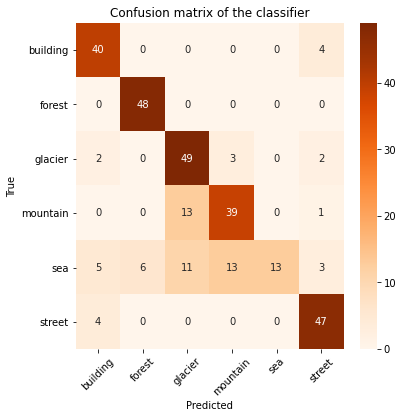

In [20]:
# we get arrays of both labels and predictions
predicts_array = np.asarray(predicts)
predicts_array_reshaped = np.reshape(predicts_array,(303,1))
testing_labels_reshaped = np.reshape(testing_labels,(303,1))

#we construct a confusion matrix
labels = ['building','forest','glacier','mountain','sea','street']
cm = confusion_matrix(testing_labels_reshaped, predicts_array_reshaped)
print(cm)

#we add some colours and labels for easier interpretation
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.title('Confusion matrix of the classifier')
seaborn.heatmap(cm,annot=True,cmap='Oranges')
ax.set_xticklabels(labels,rotation=45)
ax.set_yticklabels(labels,rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




We can see from the above confusion matrix that mostly the classifer is getting the correct labels, however we can see it is struggling with misclassifying glaciers as mountains  and vice versa which could be because they are visually quite similar. 

If better performance was required, more images of glaciers and mountains could be added to the training data so that hopefully the model would learn to better differentiate these types of images.

### Conclusion:  <a name="conclusion"></a>

We saw that with the initial model we achieved an accuracy of around 60%

We can see that with transfer learning, we achieve a roughly 30% increase in model accuracy which is significant and now the model can correctly classify 90% of images correctly. 

If greater accruacy were needed, the model could be trained for a longer period as it was only trained for a small number of epochs. Also images originally in the test folder (that became part of the validation set) could be moved into the training set to give the model more data to learn from. There is also a large number of unlabelled images in the prediction folder, if these images were manually labelled they could also be added to the training set to improve the accuracy of the algorithm. 

It should also be noted that an arbritary layer of the inception model was used as the as the cut off point for transfer learning. It is possible that using a different cut off point in the inception model may give better performance when the model is transferred tothe current dataset.

In [21]:
#tidy up and delete temp folder
shutil.rmtree('temp') 